<a href="https://colab.research.google.com/github/ravellys/PAER/blob/master/idfsV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geração de IDFs
## UFPE - CAA -  Hidrologia 2020.1

## Dados utilizados

In [ ]:
import pandas as pd

In [ ]:
nome_arquivo = 'data.csv'
df = pd.read_csv(nome_arquivo, sep='\t')

In [ ]:
df.describe()

,Year,P(mm)
count,40.000000,40.000000
mean,1998.500000,59.367500
std,11.690452,33.997703
min,1979.000000,20.900000
25%,1988.750000,40.125000
50%,1998.500000,49.900000
75%,2008.250000,69.600000
max,2018.000000,186.800000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    40 non-null     int64  
 1   P(mm)   40 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 768.0 bytes


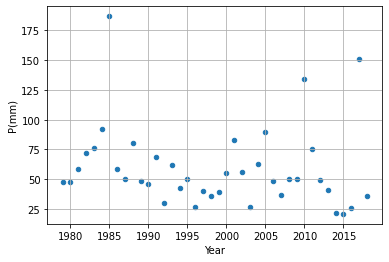

In [ ]:
df.plot(kind='scatter', x='Year', y='P(mm)', grid=True)

## Inferência estatistica

## Método Weibull

In [ ]:
# frequência empirica
def f_emp(n):
  f = []
  for i in range(1, n+1):
    f.append(i/(n+1))
  return f 

# essa função pode ser resumida como [i/(n + 1) for i in range(1,n+1)]

In [ ]:
f_emp(10)

[0.09090909090909091,
 0.18181818181818182,
 0.2727272727272727,
 0.36363636363636365,
 0.45454545454545453,
 0.5454545454545454,
 0.6363636363636364,
 0.7272727272727273,
 0.8181818181818182,
 0.9090909090909091]

In [ ]:
precipitacoes = sorted(df['P(mm)'].to_list()) # precipitações ordenadas do menor para o maior
numero_anos = len(precipitacoes)
f_exced = f_emp(numero_anos)
f_nao_exced = [1 - f for f in f_exced]

In [ ]:
df_curvapermanecia = pd.DataFrame({
    'f_exced': f_nao_exced,
    'P_emp(mm)': precipitacoes
})

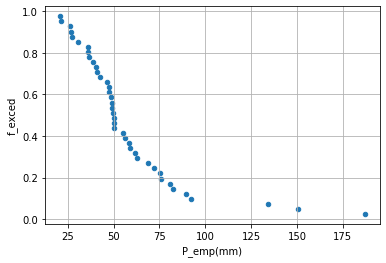

In [ ]:
df_curvapermanecia.plot(kind='scatter', x='P_emp(mm)', y='f_exced', grid=True)

## Ajuste a Gumbel

In [ ]:
import statistics
import math

PI = math.pi
desvio_padrao = statistics.pstdev(precipitacoes) 
media = statistics.mean(precipitacoes)

# parametros da distribuição de gumbel
beta = ( 6 ** 0.5 ) * desvio_padrao / PI
alfa = media - 0.577*beta

In [ ]:
def F_gumbel(y, alfa, beta):
  z = (y - alfa) / beta
  return 1 - math.exp(-math.exp(-z))

def P_gumbel(f, alfa, beta):
  z = -math.log(-math.log(1 - f))
  return alfa + z * beta

print(F_gumbel(50, alfa, beta))
print(P_gumbel(0.55, alfa, beta))

0.5521204950379851
50.15437153117119


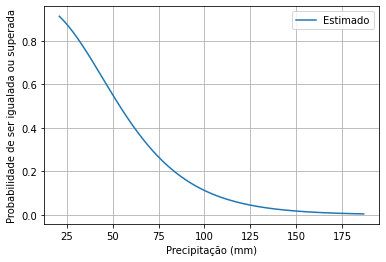

In [ ]:
## Plotando função

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data para plotagem
precipitacoes_numpy = np.arange(precipitacoes[0], precipitacoes[-1], 0.01)
frequencia_gumbel_numpy = np.array([F_gumbel(i, alfa, beta) for i in p])

fig, ax = plt.subplots()
ax.plot(precipitacoes_numpy, frequencia_gumbel_numpy, label='Estimado')

ax.set(xlabel='Precipitação (mm)', ylabel='Probabilidade de ser igualada ou superada',
       title='',)
ax.grid()
ax.legend()

plt.show()

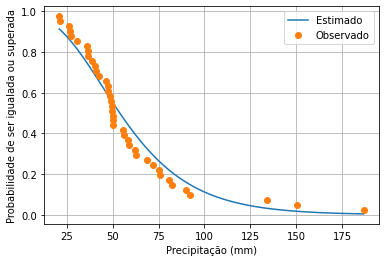

In [ ]:
# comparando frequencias
fig, ax = plt.subplots()
ax.plot(precipitacoes_numpy, frequencia_gumbel_numpy, label='Estimado')
ax.plot(df_curvapermanecia['P_emp(mm)'], df_curvapermanecia['f_exced'], 'o', label='Observado')

ax.set(xlabel='Precipitação (mm)', ylabel='Probabilidade de ser igualada ou superada',
       title='',)
ax.grid()
ax.legend()

plt.show()

In [ ]:
# Avaliar outras duas distribuições ( Weibull, GEV)

In [ ]:
# teste de aderência Kolmogorov-Smirnov, Anderson-Darlling e QuiQuadrado


## Desagregando **chuvas**

In [ ]:
def intensidade_bell(Tr, t, p_2_60):
  return (0.31*math.log(Tr) + 0.7) * (0.38 * t ** 0.31 - 0.39) * p_2_60 / (t/60)


In [ ]:
p_2_60 = 0.51 * P_gumbel(1/2, alfa, beta)

In [ ]:
tr_gerado = np.array([2, 5, 10, 25, 50, 100])#np.linspace(2, 100, 10)
t_gerado = np.linspace(5, 24*60, 1000)

intensidade = []
for row, tr in enumerate(tr_gerado):
  intensidade.append([])
  for t in t_gerado:
    intensidade[row].append(intensidade_bell(tr, t, p_2_60))

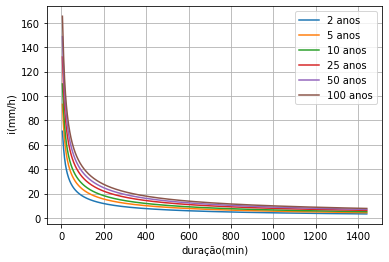

In [ ]:
fig, ax = plt.subplots()
for i, tr in zip(intensidade, tr_gerado):
  ax.plot(t_gerado, i, label=f'{int(tr)} anos')

ax.set(xlabel='duração(min)', ylabel=' i(mm/h)',
       title='',)
ax.grid()
ax.legend()

plt.show()

## Cálculo dos parametros da IDF

In [ ]:
def idf (x, t, Tr):
  a, b, c, d = x 
  return a * (b ** Tr) / (t + c) ** d

In [149]:
# Determinação de c e d 
from scipy.optimize import curve_fit

# Regressão não linear 
f_model = lambda t, A, c, d: A/(t+c) ** d
A_lista = []
c_lista = []
d_lista = []
for i in intensidade:
  x = t_gerado
  y = i
    
  popt, pcov = curve_fit(
      f=f_model,       # model function
      xdata=x,   # x data
      ydata=y,   # y data
      p0=(1000, 10, 1),      # initial value of the parameters
  )
  A, c, d = popt
  c_lista.append(c)
  d_lista.append(d)
  A_lista.append(A)


print(f'o parametro c é de {c_lista}')
print(f'o parametro d é de {d_lista}')
print(f'o parametro A é de {A_lista}')

o parametro c é de [7.260092898439834, 7.260092902056428, 7.260092944720669, 7.260092906513077, 7.260092910874262, 7.260092929487505]
o parametro d é de [0.6384948400232741, 0.6384948400616159, 0.6384948405220203, 0.6384948401040242, 0.6384948401417451, 0.638494840349557]
o parametro A é de [356.19646338809616, 466.7881633337026, 550.4475561942189, 661.0392547427617, 744.6986463223949, 828.3580387439016]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [152]:
c = statistics.mean(c_lista)
d = statistics.mean(d_lista)

In [163]:
 # determinando os parametros a e b
f_model = lambda Tr, a, b: a* (Tr ** b)

x = tr_gerado
y = A_lista
    
popt, pcov = curve_fit(
    f=f_model,       # model function
    xdata=x,   # x data
    ydata=y,   # y data
    p0=(1000, 1),      # initial value of the parameters
)
a, b = popt

print(f'o parametro a é de {round(a,2)}')
print(f'o parametro b é de {round(b,2)}')
print(f'o parametro c é de {round(c,2)}')
print(f'o parametro d é de {round(d,2)}')

o parametro a é de 335.92
o parametro b é de 0.2
o parametro c é de 7.26
o parametro d é de 0.64


In [ ]:
# Calcular métricas R² e RMSE

In [ ]:
# plotar gráfico com valores estimados